In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# visualization
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.rcParams['figure.figsize']=(16,6)
import seaborn as sns

# handling warning 
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#!pip install catboost
import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubg-finish-placement-prediction/train_V2.csv
/kaggle/input/pubg-finish-placement-prediction/test_V2.csv
/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv


## Reading the Data

In [4]:
df= pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv')
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [5]:
df.shape

(4446966, 29)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

### Data Descritption

- <b>DBNOs -</b> Number of enemy players knocked.
- **assists -** Number of enemy players this player damaged that were killed by teammates.
- **boosts -** Number of boost items used.
- **damageDealt -** Total damage dealt. Note: Self inflicted damage is subtracted.
- **headshotKills -** Number of enemy players killed with headshots.
- **heals -** Number of healing items used.
- **Id -** Player’s Id
- **killPlace -** Ranking in match of number of enemy players killed.
- **killPoints -** Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- **killStreaks -** Max number of enemy players killed in a short amount of time.
- **kills -** Number of enemy players killed.
- **longestKill -** Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- **matchDuration -** Duration of match in seconds.
- **matchId -** ID to identify match. There are no matches that are in both the training and testing set.
- **matchType -** String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- **rankPoints -** Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- **revives -** Number of times this player revived teammates.
- **rideDistance -** Total distance traveled in vehicles measured in meters.
- **roadKills -** Number of kills while in a vehicle.
- **swimDistance -** Total distance traveled by swimming measured in meters.
- **teamKills -** Number of times this player killed a teammate.
- **vehicleDestroys -** Number of vehicles destroyed.
- **walkDistance -** Total distance traveled on foot measured in meters.- 
- **weaponsAcquired -** Number of weapons picked up.
- **winPoints -** Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- **groupId -** ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- **numGroups -** Number of groups we have data for in the match.
- **maxPlace -** Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- **winPlacePerc -** The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

## Data Wrangling

#### Check for the rows with missing win prediction value 

In [7]:
# check row with null value win place perc
df[df['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [8]:
# remove that row 
df.drop(2744604, inplace = True)

## Understanding the Player distribution


In [9]:
df['playerjoined']=df.groupby('matchId')['matchId'].transform('count')
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playerjoined
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97


# **Analysing  the data**

## Kill Without Moving 

In [10]:
# prepare a data parameter to gather the information of the total distance travelled
df['totaldistance']=df['walkDistance'] + df['rideDistance'] + df['swimDistance']

# prepare a data parameter to check for anamoly detection that
# the person has not moved but still managed to do the kills
df['killwithoutmoving']=((df['kills']>0) & (df['totaldistance']==0))

## players who travel zero distance yet they have killed enemies seems suspicious, hence removing those rows!!¶

In [11]:
df[df['killwithoutmoving']==True].head()


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playerjoined,totaldistance,killwithoutmoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0,0,0,3,18,...,0.0,0,0,0.0,8,0,0.8571,58,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.6,0,0,6,33,...,0.0,0,0,0.0,22,0,0.6000,42,0.0,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.0,0,4,5,3,...,0.0,0,0,0.0,13,0,0.8947,21,0.0,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.8,0,0,0,69,...,0.0,0,0,0.0,7,1500,0.0000,73,0.0,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.0,0,1,0,37,...,0.0,0,0,0.0,10,0,0.3000,42,0.0,True


In [12]:
df[df['killwithoutmoving']==True].shape

(1535, 32)

In [13]:
# drop the table 
df.drop(df[df['killwithoutmoving'] == True].index , inplace = True)

## Extra Ordinary Road Kills

In [14]:
df[df['roadKills']>=5].shape

(82, 32)

In [15]:
df.drop(df[df['roadKills']>=5].index , inplace= True)

## So many kills -How?
In a match a player cannot not kill more that 20 kill 

In [16]:
# data dimension
df[df['kills'] > 20].shape

(417, 32)

In [17]:
# drop the instances
df.drop(df[df['kills'] > 20].index, inplace = True)

## Head Shot

In [18]:
df['headshot_rate'] = df['headshotKills']/df['kills']
df['headshot_rate'] = df['headshot_rate'].fillna(0)

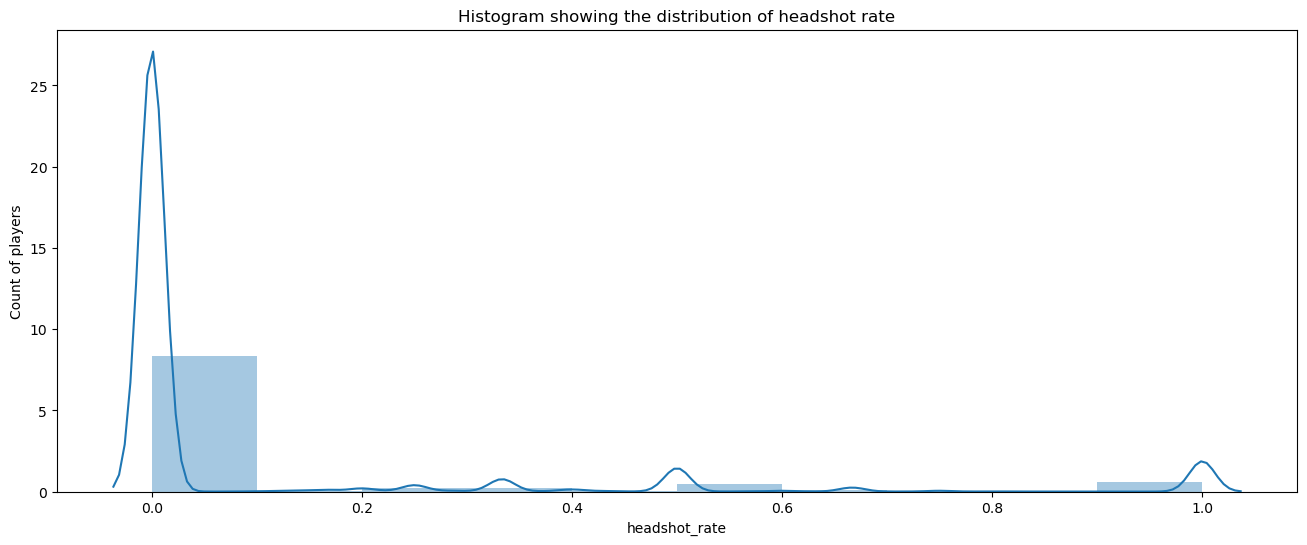

In [19]:
# plot the headshot rate distribution
sns.distplot(df['headshot_rate'], bins =10).set_title("Histogram showing the distribution of headshot rate")
plt.ylabel("Count of players")
plt.show()

In [20]:
df[(df['headshot_rate'] ==1) & (df['kills']>5)].shape

(187, 33)

In [21]:
df.drop(df[(df['headshot_rate'] == 1)& (df['kills'] > 6)].index, inplace = True)

## Longest Shot

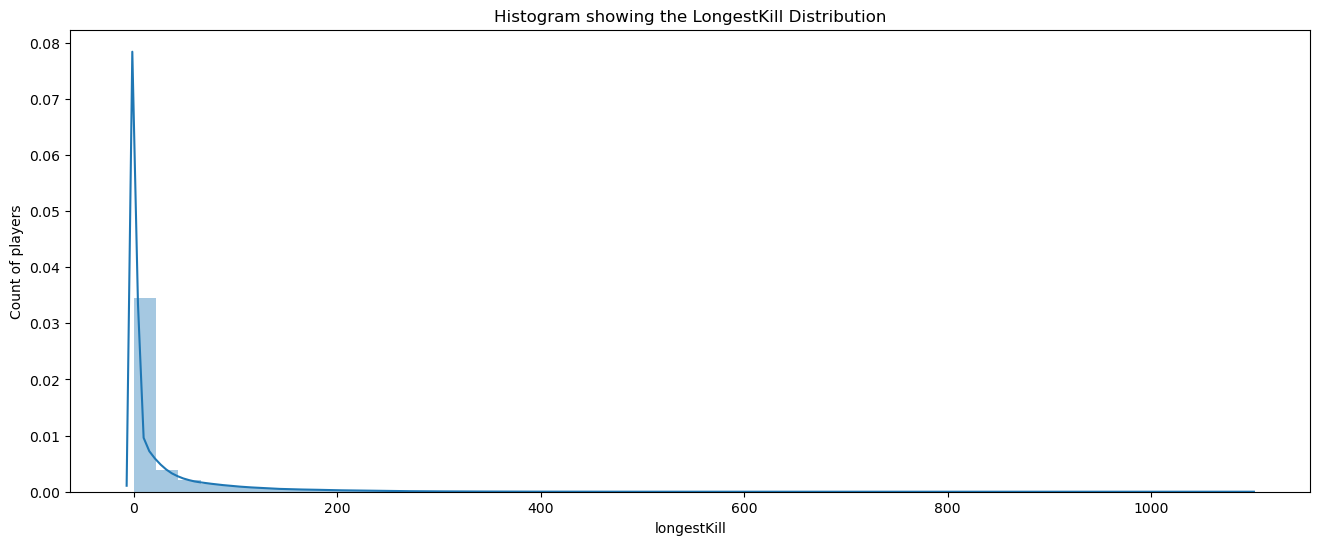

In [22]:
sns.distplot(df['longestKill'], bins = 50).set_title("Histogram showing the LongestKill Distribution")
plt.ylabel("Count of players")
plt.show()

#### if a player can kill more than 500m distance it seem suspisious player so we remove those player

In [23]:
df[df['longestKill']>=500].shape

(1747, 33)

In [24]:
df.drop(df[df['longestKill']>=500].index, inplace = True)

## Weapon Change

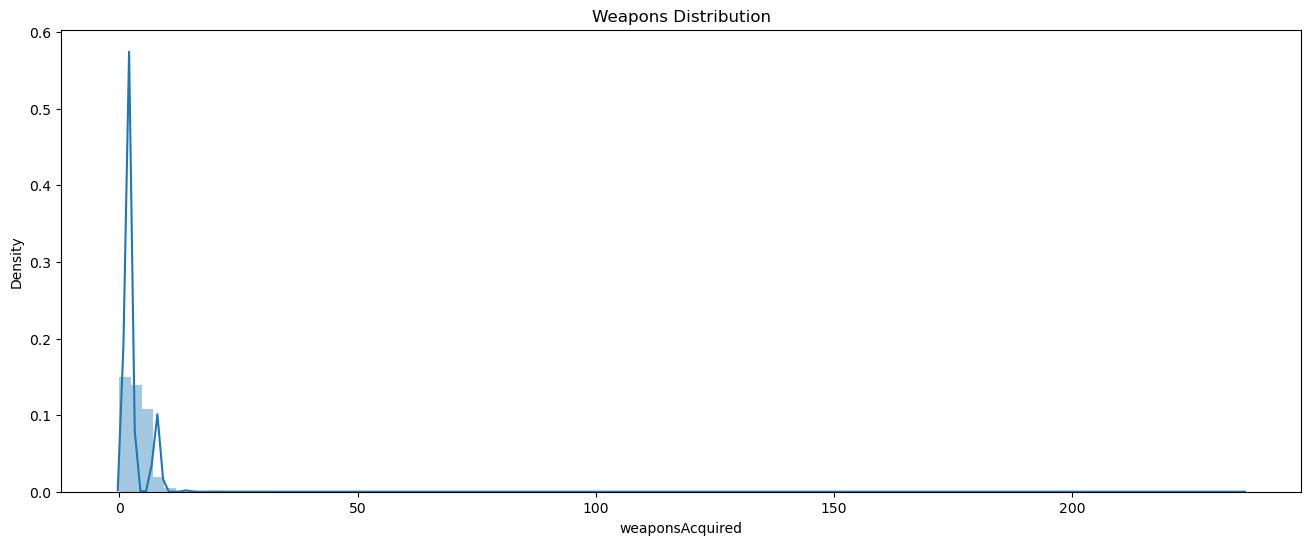

In [25]:
sns.distplot(df['weaponsAcquired'], bins=100).set_title("Weapons Distribution")
plt.show()

In [26]:
df[df['weaponsAcquired']>=15].shape

(6809, 33)

In [27]:
df.drop(df[df['weaponsAcquired']>=15].index, inplace = True)

### correlation of parameter with Win Prediction


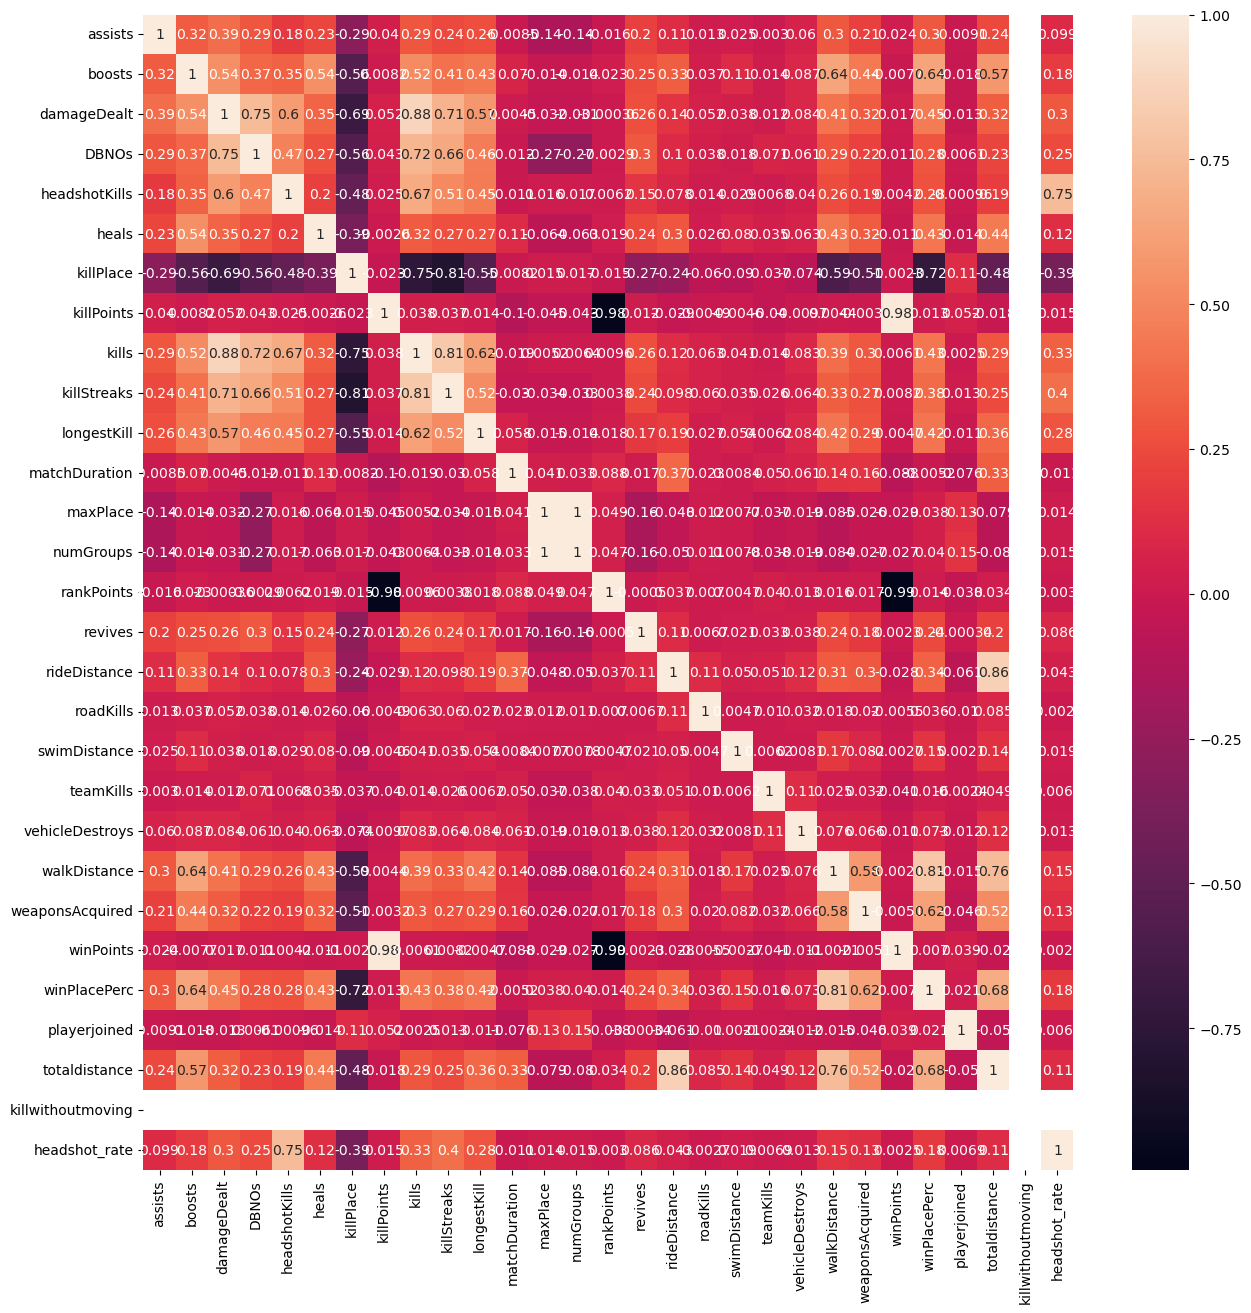

In [28]:

plt.figure(figsize=[15,15])
sns.heatmap(df.corr(), annot = True)
plt.show()

## Feature Engineering 

In [29]:
normalising_factor = (100 - df['playerjoined']/100)+1

In [30]:
df['killsNorm'] = df['kills'] * normalising_factor
df['damageDealtNorm'] = df['damageDealt'] * normalising_factor
df['maxPlaceNorm'] = df['maxPlace'] * normalising_factor
df['matchDurationNorm'] = df['matchDuration'] * normalising_factor


df['traveldistance'] = df['walkDistance'] + df['swimDistance'] + df['rideDistance']
df['healsnboosts'] = df['heals'] + df['boosts']
df['assist'] = df['assists'] + df['revives']

In [31]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'playerjoined',
       'totaldistance', 'killwithoutmoving', 'headshot_rate', 'killsNorm',
       'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm',
       'traveldistance', 'healsnboosts', 'assist'],
      dtype='object')

In [32]:
data = df.drop(columns = ['Id', 'groupId', 'matchId', 'assists', 'boosts', 'walkDistance', 'swimDistance', 
                          'rideDistance', 'heals', 'revives', 'kills', 'damageDealt', 'maxPlace', 'matchDuration'])

In [33]:
data.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,matchType,numGroups,rankPoints,roadKills,...,totaldistance,killwithoutmoving,headshot_rate,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,traveldistance,healsnboosts,assist
0,0,0,60,1241,0,0.00,squad-fpp,26,-1,0,...,244.8000,False,0.0,0.00,0.0000,2801.12,130652.24,244.8000,0,0
1,0,0,57,0,0,0.00,squad-fpp,25,1484,0,...,1445.0445,False,0.0,0.00,9155.2323,2602.34,177859.93,1445.0445,0,0
2,0,0,47,0,0,0.00,duo,47,1491,0,...,161.8000,False,0.0,0.00,6801.3600,5001.00,131826.36,161.8000,0,1
3,0,0,75,0,0,0.00,squad-fpp,30,1408,0,...,202.7000,False,0.0,0.00,3292.9610,3102.79,143729.24,202.7000,0,0
4,0,0,45,0,1,58.53,solo-fpp,95,1560,0,...,49.7500,False,0.0,100.03,10003.0000,9702.91,142442.72,49.7500,0,0


## Handeling Catogorical Data

In [34]:
data=pd.get_dummies(data, columns = ['matchType', 'killwithoutmoving'])

In [35]:
data.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,numGroups,rankPoints,roadKills,teamKills,...,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,killwithoutmoving_False
0,0,0,60,1241,0,0.00,26,-1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,57,0,0,0.00,25,1484,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,47,0,0,0.00,47,1491,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,75,0,0,0.00,30,1408,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,45,0,1,58.53,95,1560,0,0,...,0,0,0,0,0,0,1,0,0,1


In [36]:
x = data.drop(['winPlacePerc'], axis = 1)
y = data['winPlacePerc']

In [37]:
features = x.columns

## Scaling the Data

In [38]:
sc = StandardScaler()
sc.fit(x)
x = pd.DataFrame(sc.transform(x))

In [39]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.582932,-0.384019,0.449335,1.172482,-0.765139,-0.459622,-0.732883,-1.212387,-0.050058,-0.142507,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206513,-0.370798,-0.405071,1.236184,0.0
1,-0.582932,-0.384019,0.340044,-0.804730,-0.765139,-0.459622,-0.775856,0.803566,-0.050058,-0.142507,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206513,-0.370798,-0.405071,1.236184,0.0
2,-0.582932,-0.384019,-0.024259,-0.804730,-0.765139,-0.459622,0.169557,0.813069,-0.050058,-0.142507,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206513,-0.370798,-0.405071,-0.808941,0.0
3,-0.582932,-0.384019,0.995789,-0.804730,-0.765139,-0.459622,-0.560990,0.700393,-0.050058,-0.142507,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206513,-0.370798,-0.405071,1.236184,0.0
4,-0.582932,-0.384019,-0.097119,-0.804730,0.647727,0.727367,2.232278,0.906740,-0.050058,-0.142507,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206513,2.696884,-0.405071,-0.808941,0.0


### spliting the data

In [40]:
xtrain, xtest, ytrain, ytest= train_test_split(x, y, test_size = 0.3, random_state = 0)

In [41]:
print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(3105389, 40) (3105389,)
(1330881, 40) (1330881,)


# Random Forest 

In [ ]:
parameters = {
   'n_estimators':[110,130,140,150,160,180], 
   'max_depth': np.arange(2, 17, 2)
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = parameters, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(xtrain, ytrain)

In [ ]:
y_pred = grid_search.predict(x_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(ytest,y_pred ))
r2 = r2_score(ytest, y_pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

# Catboost Model


In [42]:
import catboost as cb
train_dataset = cb.Pool(xtrain, ytrain)
test_dataset = cb.Pool(xtest, ytest)

In [ ]:
#model = cb.CatBoostRegressor(loss_function='RMSE')
'''
grid = {'iterations': [100, 150], 
       'learning_rate': [0.03, 0.1], 
       'depth': [2, 4, 6,8]}

model.grid_search(grid, train_dataset)
'''

In [43]:
model = cb.CatBoostRegressor(iterations=150,learning_rate=0.1,depth=8,loss_function='RMSE')

In [44]:
 model.fit(train_dataset)

0:	learn: 0.2821439	total: 704ms	remaining: 1m 44s
1:	learn: 0.2599190	total: 1.29s	remaining: 1m 35s
2:	learn: 0.2402407	total: 1.91s	remaining: 1m 33s
3:	learn: 0.2226543	total: 2.47s	remaining: 1m 30s
4:	learn: 0.2070082	total: 3.05s	remaining: 1m 28s
5:	learn: 0.1935304	total: 3.82s	remaining: 1m 31s
6:	learn: 0.1817219	total: 4.55s	remaining: 1m 32s
7:	learn: 0.1709407	total: 5.12s	remaining: 1m 30s
8:	learn: 0.1614802	total: 5.68s	remaining: 1m 29s
9:	learn: 0.1531627	total: 6.21s	remaining: 1m 27s
10:	learn: 0.1458855	total: 6.77s	remaining: 1m 25s
11:	learn: 0.1396485	total: 7.32s	remaining: 1m 24s
12:	learn: 0.1342534	total: 7.85s	remaining: 1m 22s
13:	learn: 0.1293345	total: 8.41s	remaining: 1m 21s
14:	learn: 0.1252131	total: 8.98s	remaining: 1m 20s
15:	learn: 0.1214044	total: 9.48s	remaining: 1m 19s
16:	learn: 0.1182789	total: 9.96s	remaining: 1m 17s
17:	learn: 0.1153782	total: 10.5s	remaining: 1m 16s
18:	learn: 0.1129754	total: 11s	remaining: 1m 15s
19:	learn: 0.1106171	tot

In [45]:
pred = model.predict(xtest)

In [46]:
rmse = np.sqrt(mean_squared_error(ytest, pred))
r2 = r2_score(ytest, pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 0.08
R2: 0.93


In [47]:
feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = features
feature_importance_df['importance'] = model.feature_importances_

feature_importance_df = feature_importance_df.sort_values(by = ['importance'], ascending=False)

In [48]:
feature_importance_df

,features,importance
2,killPlace,41.072101
14,totaldistance,13.165149
16,killsNorm,12.128176
20,traveldistance,11.119042
19,matchDurationNorm,5.292724
13,playerjoined,4.583709
4,killStreaks,4.325772
6,numGroups,2.118872
21,healsnboosts,1.800286
0,DBNOs,1.288038


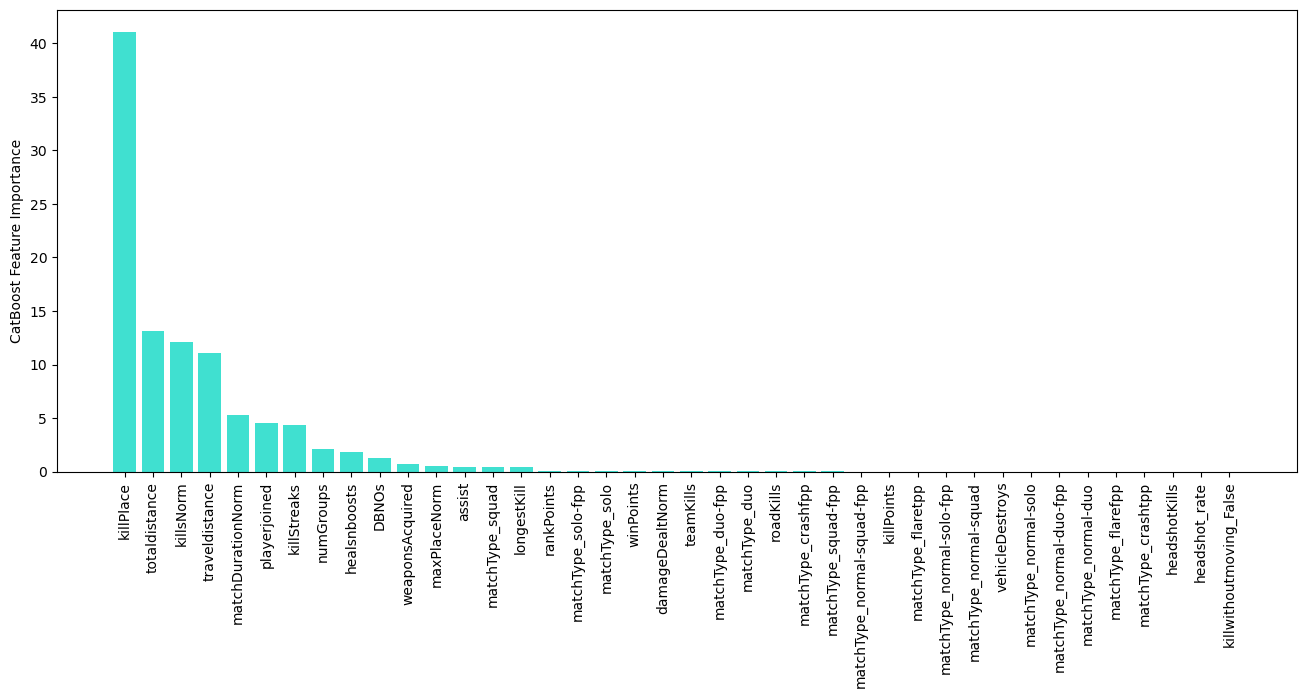

In [49]:
plt.bar(feature_importance_df.features, feature_importance_df.importance, color='turquoise')
plt.ylabel("CatBoost Feature Importance")
plt.xticks(rotation = 90)
plt.show()